In [29]:
import sklearn
import warnings
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split

# warning handleing 
warnings.filterwarnings("ignore")


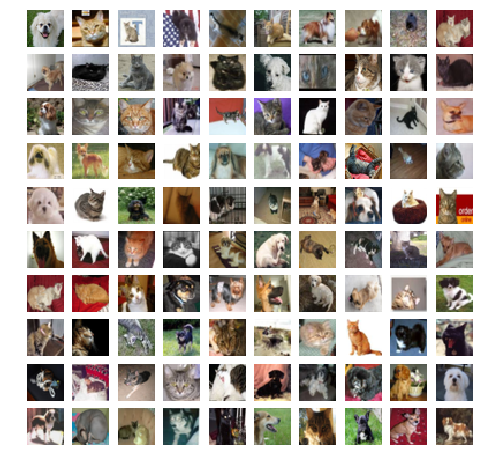

In [44]:
cifar_file = ["cifar-10-batches-py/data_batch_1", "cifar-10-batches-py/data_batch_2", "cifar-10-batches-py/data_batch_3", "cifar-10-batches-py/data_batch_4", "cifar-10-batches-py/data_batch_5"]

def unpickle(file):
    import pickle
    with open(f, 'rb') as fo:
      dict = pickle.load(fo, encoding='bytes')
    return dict

batches = []
for f in cifar_file:
  batches.append(unpickle(f))

data = []
label = []

for batch in batches:    
  for row in range(len(batch[b'labels'])):
      if batch[b'labels'][row] == 3 or batch[b'labels'][row] == 5:
          data.append(batch[b'data'][row]) 
          label.append(batch[b'labels'][row])

dat = np.concatenate(data)
labels = [int(x == 5) for x in label]


# reshape image data and display a grid of images
m = 32
n = 32
X = dat.reshape(10000, 3, m, n).transpose(0,2,3,1).astype("uint8")
y = np.array(labels)


# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)


nrows = 10
ncols = 10
fig, axes1 = plt.subplots(nrows,ncols,figsize=(8,8))
for j in range(nrows):
    for k in range(ncols):
        i = np.random.choice(range(len(X)))
        img = X[i:i+1][0]
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(img)

In [45]:
# parameters
height = 32
width = 32
channels = 3
n_inputs = height * width

conv1_fmaps = 20
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 50 #was 64
conv2_ksize = 3
conv2_stride = 2
conv2_pad = "SAME"

pool3_fmaps = 200

n_fc1 = 64 #was 64
n_outputs = 2

dropout_rate = 0.5

In [46]:
tf.reset_default_graph()

# training = tf.placeholder_with_default(False, shape=(None, 32, 32, 3), name='training')
X_drop = tf.layers.dropout(X, dropout_rate)

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, height, width, channels], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")


conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")

conv1_drop = tf.layers.dropout(conv1, dropout_rate)

conv2 = tf.layers.conv2d(conv1_drop, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")

conv2_drop = tf.layers.dropout(conv2, dropout_rate)

conv3 = tf.layers.conv2d(conv2, filters=200, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv3")

In [47]:
with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv3, ksize=[1, 6, 6, 1], strides=[1, 2, 2, 1], padding="VALID")
    #bn = tf.layers.batch_normalization(pool3)
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 2 * 2])


with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.relu, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [48]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [49]:
n_epochs = 15
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", "{0:.2f}".format(round(acc_train, 4)), "  |   Test accuracy:", round(acc_test, 4))

        # save_path = saver.save(sess, "./my_mnist_model")

0 Train accuracy: 0.50   |   Test accuracy: 0.609
1 Train accuracy: 0.70   |   Test accuracy: 0.6225
2 Train accuracy: 0.68   |   Test accuracy: 0.6555
3 Train accuracy: 0.86   |   Test accuracy: 0.6645
4 Train accuracy: 0.82   |   Test accuracy: 0.6775
5 Train accuracy: 0.82   |   Test accuracy: 0.694
6 Train accuracy: 0.92   |   Test accuracy: 0.674
7 Train accuracy: 0.94   |   Test accuracy: 0.684
8 Train accuracy: 0.96   |   Test accuracy: 0.675
9 Train accuracy: 0.92   |   Test accuracy: 0.674
10 Train accuracy: 0.94   |   Test accuracy: 0.661
11 Train accuracy: 0.98   |   Test accuracy: 0.6665
12 Train accuracy: 0.86   |   Test accuracy: 0.6405
13 Train accuracy: 0.94   |   Test accuracy: 0.687
14 Train accuracy: 0.94   |   Test accuracy: 0.6885
